<a href="https://colab.research.google.com/github/GLEON/realsat/blob/master/Example_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORT LIBRARIES

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch.utils.data.dataset import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder

# CONNECT GOOGLE DRIVE (DATA DIRECTORY) TO GOOGLE COLAB

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
DATASET = "EMOTION_DATASET"
INPUT_DIR = os.path.join("INPUT", DATASET)

YOUR_DIR = os.path.join("jsta", DATASET)
MODEL_DIR = os.path.join(YOUR_DIR, "MODEL")
RESULT_DIR = os.path.join(YOUR_DIR, "RESULT")

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

This notebook solves the time-series classification problem using Multi-layer Perceptron model. We solve the emotion classification problem where the input is a time series of length 259 and the classes are positive, neutral and negative emotion.

## HYPERPARAMETERS

In [4]:
batch_size = 50
time_steps = 259
channels = 1
classes = 3
learning_rate = 0.005
epochs = 200

# LOADING DATA

In [5]:
print("#######################################################################")
print("LOAD DATA")
X = np.load(
    os.path.join(INPUT_DIR, "X_3_emotion_all_augmented_1.npy"), allow_pickle=True
).astype(np.float32)
y = np.load(
    os.path.join(INPUT_DIR, "y_3_emotion_all_augmented_1.npy"), allow_pickle=True
)
print(X.shape, y.shape)

print("#######################################################################")
print("TRAIN VAL TEST SPLIT")
train_X, test_X, train_y, test_y = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
train_X, val_X, train_y, val_y = train_test_split(
    train_X, train_y, test_size=0.2, random_state=42, stratify=train_y
)
print(train_X.shape, train_y.shape, Counter(train_y))
print(val_X.shape, val_y.shape, Counter(val_y))
print(test_X.shape, test_y.shape, Counter(test_y))

print("#######################################################################")
print("PREPROCESS LABELS")
le = LabelEncoder()
le.fit(train_y)
print("CLASSES:{}".format(le.classes_))
train_y = le.transform(train_y)
val_y = le.transform(val_y)
test_y = le.transform(test_y)

print("#######################################################################")
print("PREPROCESS INPUTS")
mean = np.mean(train_X)
std = np.std(train_X)
train_X = (train_X - mean) / std
val_X = (val_X - mean) / std
test_X = (test_X - mean) / std

print("#######################################################################")
print("DATA LOADER")


class loader(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]


train_data = loader(X=train_X, y=train_y)
train_loader = torch.utils.data.DataLoader(
    dataset=train_data, batch_size=batch_size, shuffle=True, num_workers=0
)
val_data = loader(X=val_X, y=val_y)
val_loader = torch.utils.data.DataLoader(
    dataset=val_data, batch_size=batch_size, shuffle=True, num_workers=0
)
test_data = loader(X=test_X, y=test_y)
test_loader = torch.utils.data.DataLoader(
    dataset=test_data, batch_size=batch_size, shuffle=True, num_workers=0
)
print(
    "Train batch:{}\tVal batch:{}\tTest batch:{}".format(
        len(train_loader), len(val_loader), len(test_loader)
    )
)

#######################################################################
LOAD DATA
(5760, 259) (5760,)
#######################################################################
TRAIN VAL TEST SPLIT
(3686, 259) (3686,) Counter({'negative': 2457, 'neutral': 738, 'positive': 491})
(922, 259) (922,) Counter({'negative': 615, 'neutral': 184, 'positive': 123})
(1152, 259) (1152,) Counter({'negative': 768, 'neutral': 230, 'positive': 154})
#######################################################################
PREPROCESS LABELS
CLASSES:['negative' 'neutral' 'positive']
#######################################################################
PREPROCESS INPUTS
#######################################################################
DATA LOADER
Train batch:74	Val batch:19	Test batch:24


# DEFINE MODEL

In [6]:
print("#######################################################################")
print("DEFINE MODEL")


class ANN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ANN, self).__init__()
        self.fc_1 = torch.nn.Linear(in_channels, 32)
        self.fc_2 = torch.nn.Linear(32, out_channels)

        self.relu = torch.nn.ReLU()

        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        x_fc_1 = self.relu(self.fc_1(x))
        out = self.fc_2(x_fc_1)
        return out


print("#######################################################################")
print("BUILD MODEL")
model = ANN(in_channels=time_steps, out_channels=classes)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

print(model)

#######################################################################
DEFINE MODEL
#######################################################################
BUILD MODEL
ANN(
  (fc_1): Linear(in_features=259, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
)


# TRAINING MODEL

#######################################################################
TRAIN MODEL


Epoch:1	Train Loss:0.8661919425468187	Val Loss:0.804176245865069	Train Score:0.3961	Val Score:0.3528	Max Score:0.0000


Epoch:2	Train Loss:0.7835109354676427	Val Loss:0.775190460054498	Train Score:0.4186	

Val Score:0.3722	Max Score:0.3528
Epoch:3	Train Loss:0.7497807278020961	Val Loss:0.7597181326464603	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.4360	Val Score:0.3770	Max Score:0.3722
Epoch:4	Train Loss:0.7282155744127325	Val Loss:0.7404225311781231	

Train Score:0.4779	Val Score:0.4321	Max Score:0.3770


Epoch:5	Train Loss:0.7145284833134832	Val Loss:0.7513944349790874	Train Score:0.4619	Val Score:0.4103	Max Score:0.4321


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:6	Train Loss:0.7055371411748834	Val Loss:0.7453720350014535	Train Score:0.4421	Val Score:0.4056	Max Score:0.4321


Epoch:7	Train Loss:0.6888768850146113	Val Loss:0.7238162630482724	

Train Score:0.5406	Val Score:0.4766	Max Score:0.4321
Epoch:8	Train Loss:0.6815069615840912	Val Loss:0.7101027542038968	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.5006	Val Score:0.4428	Max Score:0.4766
Epoch:9	Train Loss:0.6638736555705199	Val Loss:0.7218392522711503	

Train Score:0.5325	Val Score:0.4662	Max Score:0.4766


Epoch:10	Train Loss:0.6750780517185057	Val Loss:0.716029250308087	Train Score:0.5143	Val Score:0.4483	Max Score:0.4766


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:11	Train Loss:0.6537851191855766	Val Loss:0.7106768990817823	Train Score:0.5402	Val Score:0.4644	Max Score:0.4766


Epoch:12	Train Loss:0.6511019512608245	Val Loss:0.7280284856495104	

Train Score:0.5443	Val Score:0.5005	Max Score:0.4766
Epoch:13	Train Loss:0.6407101408049867	Val Loss:0.6869309419079831	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.5358	Val Score:0.4738	Max Score:0.5005
Epoch:14	Train Loss:0.6309525777359266	Val Loss:0.6829912725247835	

Train Score:0.5540	Val Score:0.5143	Max Score:0.5005


Epoch:15	Train Loss:0.6162151633887678	Val Loss:0.7254477990301031	Train Score:0.4981	Val Score:0.4484	Max Score:0.5143


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:16	Train Loss:0.621397819873449	Val Loss:0.7185185269305581	Train Score:0.5609	Val Score:0.4905	Max Score:0.5143


Epoch:17	Train Loss:0.6033718686651539	Val Loss:0.705995471853959	

Train Score:0.5995	Val Score:0.5282	Max Score:0.5143
Epoch:18	Train Loss:0.5971093894662084	Val Loss:0.6945318956124155	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.5859	Val Score:0.5352	Max Score:0.5282
Epoch:19	Train Loss:0.6007546673755388	Val Loss:0.7003391416449296	

Train Score:0.5427	Val Score:0.4715	Max Score:0.5352


Epoch:20	Train Loss:0.5892627694316812	Val Loss:0.7088540290531359	Train Score:0.5767	Val Score:0.5037	Max Score:0.5352


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:21	Train Loss:0.5861947915038547	Val Loss:0.6975405153475309	Train Score:0.5919	Val Score:0.4863	Max Score:0.5352


Epoch:22	Train Loss:0.5808141992704289	Val Loss:0.6936978431124436	

Train Score:0.5905	Val Score:0.5079	Max Score:0.5352
Epoch:23	Train Loss:0.5725303078825409	Val Loss:0.7153268393717314	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.6040	Val Score:0.5185	Max Score:0.5352
Epoch:24	Train Loss:0.5734576872877173	Val Loss:0.6952121477378043	

Train Score:0.5964	Val Score:0.4860	Max Score:0.5352


Epoch:25	Train Loss:0.5553559439407812	Val Loss:0.7273729882742229	Train Score:0.5737	Val Score:0.4891	Max Score:0.5352


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:26	Train Loss:0.5457712854887988	Val Loss:0.7007985146422135	Train Score:0.6079	Val Score:0.5138	Max Score:0.5352


Epoch:27	Train Loss:0.542915665217348	Val Loss:0.7338735006357494	

Train Score:0.6304	Val Score:0.5149	Max Score:0.5352
Epoch:28	Train Loss:0.5357274662803959	Val Loss:0.7557079635168377	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.6083	Val Score:0.4993	Max Score:0.5352
Epoch:29	Train Loss:0.5284348830983445	Val Loss:0.7275190620045913	

Train Score:0.6050	Val Score:0.5076	Max Score:0.5352


Epoch:30	Train Loss:0.5275289609625533	Val Loss:0.7129901976961839	Train Score:0.6415	Val Score:0.5360	Max Score:0.5352


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:31	Train Loss:0.5209805063299231	Val Loss:0.6957843727187106	Train Score:0.6521	Val Score:0.5315	Max Score:0.5360


Epoch:32	Train Loss:0.5198780692912437	Val Loss:0.6908552897603888	

Train Score:0.6772	Val Score:0.5389	Max Score:0.5360
Epoch:33	Train Loss:0.5026008023603542	Val Loss:0.6924064018224415	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.6921	Val Score:0.5493	Max Score:0.5389
Epoch:34	Train Loss:0.49307084808478485	Val Loss:0.7175258052976508	

Train Score:0.6738	Val Score:0.5563	Max Score:0.5493


Epoch:35	Train Loss:0.5075068171765353	Val Loss:0.7456856464084826	Train Score:0.6449	Val Score:0.5210	Max Score:0.5563


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:36	Train Loss:0.4967754547660415	Val Loss:0.7185227682715968	Train Score:0.6797	Val Score:0.5448	Max Score:0.5563


Epoch:37	Train Loss:0.48652119451277964	Val Loss:0.7330715499426189	

Train Score:0.7042	Val Score:0.5537	Max Score:0.5563
Epoch:38	Train Loss:0.5115300954596417	Val Loss:0.7004159375240928	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.6743	Val Score:0.5537	Max Score:0.5563
Epoch:39	Train Loss:0.49536408524255493	Val Loss:0.7888457492778176	

Train Score:0.6532	Val Score:0.5266	Max Score:0.5563


Epoch:40	Train Loss:0.5201146050884917	Val Loss:0.8413808502649006	Train Score:0.6641	Val Score:0.5216	Max Score:0.5563


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:41	Train Loss:0.49370969107022156	Val Loss:0.780321478843689	Train Score:0.6769	Val Score:0.5449	Max Score:0.5563


Epoch:42	Train Loss:0.4886741952316181	Val Loss:0.7814637234336451	

Train Score:0.7026	Val Score:0.5778	Max Score:0.5563
Epoch:43	Train Loss:0.47087546015107956	Val Loss:0.7653745428511971	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.7121	Val Score:0.5413	Max Score:0.5778
Epoch:44	Train Loss:0.48236810979810923	Val Loss:0.7250249966194755	

Train Score:0.6955	Val Score:0.5483	Max Score:0.5778


Epoch:45	Train Loss:0.4717950575255059	Val Loss:0.734888062665337	Train Score:0.6924	Val Score:0.5540	Max Score:0.5778


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:46	Train Loss:0.45469797261663386	Val Loss:0.7655859432722393	Train Score:0.7150	Val Score:0.5627	Max Score:0.5778


Epoch:47	Train Loss:0.45767466039270965	Val Loss:0.7358368133243761	

Train Score:0.7395	Val Score:0.5784	Max Score:0.5778
Epoch:48	Train Loss:0.4635741763018273	Val Loss:0.7891847663804105	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.7089	Val Score:0.5610	Max Score:0.5784
Epoch:49	Train Loss:0.45700000427864695	Val Loss:0.7453107567209947	

Train Score:0.7289	Val Score:0.5633	Max Score:0.5784


Epoch:50	Train Loss:0.43866792965579676	Val Loss:0.8059474794488204	Train Score:0.6654	Val Score:0.5152	Max Score:0.5784


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:51	Train Loss:0.4541535164053376	Val Loss:0.7820078981550116	Train Score:0.6602	Val Score:0.5255	Max Score:0.5784


Epoch:52	Train Loss:0.47008176671492086	Val Loss:0.7543564470190751	

Train Score:0.7045	Val Score:0.5425	Max Score:0.5784
Epoch:53	Train Loss:0.4422493262870892	Val Loss:0.7965439432545712	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.6879	Val Score:0.5321	Max Score:0.5784
Epoch:54	Train Loss:0.4329612408135388	Val Loss:0.8482214839834916	

Train Score:0.7178	Val Score:0.5627	Max Score:0.5784


Epoch:55	Train Loss:0.4489799536563255	Val Loss:0.7873545728231731	Train Score:0.7251	Val Score:0.5634	Max Score:0.5784


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:56	Train Loss:0.43796376440976115	Val Loss:0.7622618126241785	Train Score:0.7479	Val Score:0.5756	Max Score:0.5784


Epoch:57	Train Loss:0.4229306379282797	Val Loss:0.8488661521359494	

Train Score:0.7299	Val Score:0.5449	Max Score:0.5784
Epoch:58	Train Loss:0.41031490064956044	Val Loss:0.7503057090859664	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.7729	Val Score:0.5907	Max Score:0.5784
Epoch:59	Train Loss:0.40576385525432795	Val Loss:0.7661366525449251	

Train Score:0.7412	Val Score:0.5417	Max Score:0.5907


Epoch:60	Train Loss:0.40146054830905553	Val Loss:0.822538004109734	Train Score:0.7212	Val Score:0.5425	Max Score:0.5907


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:61	Train Loss:0.42385237643847595	Val Loss:0.8098692548902411	Train Score:0.7552	Val Score:0.5776	Max Score:0.5907


Epoch:62	Train Loss:0.4072880390528086	Val Loss:0.7838105763259687	

Train Score:0.7612	Val Score:0.5735	Max Score:0.5907
Epoch:63	Train Loss:0.4021881887236157	Val Loss:0.801365392772775	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.7608	Val Score:0.5596	Max Score:0.5907
Epoch:64	Train Loss:0.4199200437681095	Val Loss:0.793223931601173	

Train Score:0.7578	Val Score:0.5690	Max Score:0.5907


Epoch:65	Train Loss:0.4248218377296989	Val Loss:0.8133045889829335	Train Score:0.7397	Val Score:0.5699	Max Score:0.5907


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:66	Train Loss:0.40215862643074346	Val Loss:0.7939851064431039	Train Score:0.7738	

Val Score:0.5688	Max Score:0.5907


Epoch:67	Train Loss:0.38429886585957296	Val Loss:0.8559248870924899	Train Score:0.7625	Val Score:0.5556	Max Score:0.5907


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:68	Train Loss:0.3969353139400482	Val Loss:0.7807767297092237	

Train Score:0.7602	Val Score:0.5745	Max Score:0.5907


Epoch:69	Train Loss:0.3820381543120822	Val Loss:0.8152160770014713	Train Score:0.7736	Val Score:0.5881	Max Score:0.5907
Epoch:70	Train Loss:0.3727527862867793	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Val Loss:0.8350909571898611	Train Score:0.7706	

Val Score:0.5761	Max Score:0.5907
Epoch:71	Train Loss:0.3730125825952839	Val Loss:0.8265162235812137	

Train Score:0.7846	Val Score:0.5612	Max Score:0.5907
Epoch:72	Train Loss:0.4006555497243598	Val Loss:0.7951044314786008	

<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Train Score:0.7780	Val Score:0.5787	Max Score:0.5907


Epoch:73	Train Loss:0.39038873403458985	Val Loss:0.8861405629860727	

Train Score:0.7415	Val Score:0.5668	Max Score:0.5907


Epoch:74	Train Loss:0.38974897684277715	Val Loss:0.8540472262784055	Train Score:0.7766	Val Score:0.5948	Max Score:0.5907


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:75	Train Loss:0.36138821755712097	Val Loss:0.8361207968310306	Train Score:0.7905	Val Score:0.5866	Max Score:0.5948


Epoch:76	Train Loss:0.38055738645630915	Val Loss:0.87058298838766	Train Score:0.7961	Val Score:0.5776	Max Score:0.5948


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:77	Train Loss:0.3585092107186446	Val Loss:0.8853414215539631	Train Score:0.7840	

Val Score:0.5849	Max Score:0.5948
Epoch:78	Train Loss:0.3616207892427573	Val Loss:0.8642427544844778	Train Score:0.7669	Val Score:0.5539	Max Score:0.5948


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:79	Train Loss:0.35246799523765976	Val Loss:0.8307523413708335	Train Score:0.7859	Val Score:0.5961	Max Score:0.5948
Epoch:80	Train Loss:0.35541409626603127	Val Loss:0.8319409128866697	Train Score:0.8023	Val Score:0.6063	Max Score:0.5961


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:81	Train Loss:0.36507938037047516	Val Loss:0.825301120155736	Train Score:0.8006	Val Score:0.5888	Max Score:0.6063
Epoch:82	Train Loss:0.36602216455582026	Val Loss:0.8750831625963512	Train Score:0.7604	Val Score:0.5580	Max Score:0.6063


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:83	Train Loss:0.381156619336154	Val Loss:0.9029747482977415	Train Score:0.7852	Val Score:0.5994	Max Score:0.6063
Epoch:84	Train Loss:0.3686181751860155	Val Loss:0.8455121689721158	Train Score:0.7803	Val Score:0.5748	Max Score:0.6063


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:85	Train Loss:0.3540863302108404	Val Loss:0.8262318278613844	Train Score:0.8063	Val Score:0.6026	Max Score:0.6063
Epoch:86	Train Loss:0.3415465608641908	Val Loss:0.8814665298712882	Train Score:0.8170	Val Score:0.6043	Max Score:0.6063


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:87	Train Loss:0.3549706319699416	Val Loss:0.8566704564972928	Train Score:0.7882	Val Score:0.5994	Max Score:0.6063
Epoch:88	Train Loss:0.37517037303061096	Val Loss:0.9445311489858126	Train Score:0.7731	Val Score:0.5784	Max Score:0.6063


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:89	Train Loss:0.337561575544847	Val Loss:0.8530933135434201	Train Score:0.8114	Val Score:0.5921	Max Score:0.6063
Epoch:90	Train Loss:0.3523208835237735	Val Loss:0.8801685524614233	Train Score:0.8010	Val Score:0.5872	Max Score:0.6063


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:91	Train Loss:0.34672009522044983	Val Loss:0.89809418979444	Train Score:0.8060	Val Score:0.5952	Max Score:0.6063
Epoch:92	Train Loss:0.33816451458512126	Val Loss:0.828817893015711	Train Score:0.8001	Val Score:0.5795	Max Score:0.6063


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:93	Train Loss:0.35736033139196605	Val Loss:0.873627676775581	Train Score:0.8032	Val Score:0.5885	Max Score:0.6063
Epoch:94	Train Loss:0.35200492534283045	Val Loss:0.9298853089934901	Train Score:0.7767	Val Score:0.5590	Max Score:0.6063


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:95	Train Loss:0.3339759739669594	Val Loss:0.9532799438426369	Train Score:0.7976	Val Score:0.5880	Max Score:0.6063
Epoch:96	Train Loss:0.3173942165197553	Val Loss:0.877344747907237	Train Score:0.8179	Val Score:0.5967	Max Score:0.6063


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:97	Train Loss:0.3243627369001105	Val Loss:0.9575191751906746	Train Score:0.7992	Val Score:0.5989	Max Score:0.6063
Epoch:98	Train Loss:0.3258840939080393	Val Loss:0.8760574052208349	Train Score:0.8276	Val Score:0.5857	Max Score:0.6063


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:99	Train Loss:0.3210468964802252	Val Loss:0.8726373471711811	Train Score:0.8277	Val Score:0.6040	Max Score:0.6063
Epoch:100	Train Loss:0.31836901907179804	Val Loss:0.9473101857461428	Train Score:0.7894	Val Score:0.5888	Max Score:0.6063


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:101	Train Loss:0.31838100081360016	Val Loss:0.9609109022115406	Train Score:0.8242	Val Score:0.5900	Max Score:0.6063
Epoch:102	Train Loss:0.3173568403801402	Val Loss:0.8672144287510922	Train Score:0.8138	Val Score:0.6086	Max Score:0.6063


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:103	Train Loss:0.30987967027200236	Val Loss:0.9596191519185117	Train Score:0.8111	Val Score:0.5970	Max Score:0.6086
Epoch:104	Train Loss:0.32703474486196366	Val Loss:0.9461814321969685	Train Score:0.8216	Val Score:0.5838	Max Score:0.6086


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:105	Train Loss:0.330098522877371	Val Loss:0.9574991119535345	Train Score:0.8255	Val Score:0.5959	Max Score:0.6086
Epoch:106	Train Loss:0.30924432704577576	Val Loss:0.9304609800639906	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.7959	Val Score:0.6012	Max Score:0.6086
Epoch:107	Train Loss:0.33250103468025055	Val Loss:0.9839635177662498	Train Score:0.8005	Val Score:0.5969	Max Score:0.6086


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:108	Train Loss:0.3061801310930703	Val Loss:0.949372156670219	Train Score:0.8064	Val Score:0.5842	Max Score:0.6086
Epoch:109	Train Loss:0.31298870915496674	Val Loss:0.944926779521139	Train Score:0.8120	Val Score:0.6085	Max Score:0.6086


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:110	Train Loss:0.31884224491344915	Val Loss:0.921909224045904	Train Score:0.8269	Val Score:0.5998	Max Score:0.6086
Epoch:111	Train Loss:0.29178641051859466	Val Loss:1.0083006526294507	Train Score:0.8224	Val Score:0.5932	Max Score:0.6086


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:112	Train Loss:0.2977817835840019	Val Loss:0.9419550205531874	Train Score:0.8340	Val Score:0.6159	Max Score:0.6086
Epoch:113	Train Loss:0.3054209001160957	Val Loss:0.9693093017527932	Train Score:0.8351	Val Score:0.6204	Max Score:0.6159


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:114	Train Loss:0.2986517473048455	Val Loss:0.9544277363701871	Train Score:0.8162	Val Score:0.5932	Max Score:0.6204
Epoch:115	Train Loss:0.3147025740629918	Val Loss:0.9372949804130354	Train Score:0.8381	Val Score:0.6016	Max Score:0.6204


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:116	Train Loss:0.31634942140128164	Val Loss:1.0423700621253567	Train Score:0.8115	Val Score:0.5948	Max Score:0.6204
Epoch:117	Train Loss:0.34488472181397517	Val Loss:1.01025947144157	Train Score:0.8197	Val Score:0.5945	Max Score:0.6204


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:118	Train Loss:0.34673661436583547	Val Loss:0.9829283137070505	Train Score:0.8095	Val Score:0.5956	Max Score:0.6204
Epoch:119	Train Loss:0.3112846876721124	Val Loss:0.9304544266901518	Train Score:0.8494	Val Score:0.6085	Max Score:0.6204


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:120	Train Loss:0.2855263507446727	Val Loss:0.9572079464008934	Train Score:0.8301	Val Score:0.6168	Max Score:0.6204
Epoch:121	Train Loss:0.29650993947241755	Val Loss:0.9939726685222826	Train Score:0.8331	Val Score:0.5960	Max Score:0.6204


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:122	Train Loss:0.29934626213602117	Val Loss:0.9733792261073464	Train Score:0.8550	Val Score:0.6203	Max Score:0.6204
Epoch:123	Train Loss:0.2785253172387948	Val Loss:0.9731440136307165	Train Score:0.8635	Val Score:0.6370	Max Score:0.6204


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:124	Train Loss:0.2727735167419588	Val Loss:1.0024336074527942	Train Score:0.8356	Val Score:0.6293	Max Score:0.6370
Epoch:125	Train Loss:0.26696225296001175	Val Loss:1.0052053363699662	Train Score:0.8475	Val Score:0.6086	Max Score:0.6370


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:126	Train Loss:0.30403304261130254	Val Loss:1.0652647567422766	Train Score:0.7955	Val Score:0.6052	Max Score:0.6370
Epoch:127	Train Loss:0.2803437669534941	Val Loss:1.1105755944001048	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.8555	Val Score:0.6258	Max Score:0.6370
Epoch:128	Train Loss:0.26441621679711985	Val Loss:0.9885689286809218	Train Score:0.8618	Val Score:0.6245	Max Score:0.6370
Epoch:129	Train Loss:0.28162186653227417	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Val Loss:1.0102306823981435	Train Score:0.8263	Val Score:0.5972	Max Score:0.6370
Epoch:130	Train Loss:0.27759989210077235	Val Loss:1.0127606548761066	Train Score:0.8533	Val Score:0.6244	Max Score:0.6370


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:131	Train Loss:0.3270855831938821	Val Loss:1.0520171272127252	Train Score:0.8182	Val Score:0.6029	Max Score:0.6370
Epoch:132	Train Loss:0.2867466735880117	Val Loss:1.0603940675133152	Train Score:0.8584	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Val Score:0.6266	Max Score:0.6370
Epoch:133	Train Loss:0.27919623628258705	Val Loss:1.0131282414260663	Train Score:0.8467	Val Score:0.6256	Max Score:0.6370
Epoch:134	Train Loss:0.2794974101959048	

Val Loss:0.9959382854009929	Train Score:0.8629	Val Score:0.6176	Max Score:0.6370
Epoch:135	Train Loss:0.26437458083839027	Val Loss:1.0171762955816168	Train Score:0.8489	Val Score:0.6136	Max Score:0.6370


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:136	Train Loss:0.25867452975865957	Val Loss:1.042797697217841	Train Score:0.8585	Val Score:0.6057	Max Score:0.6370
Epoch:137	Train Loss:0.2651660406106227	Val Loss:1.1222668070542186	Train Score:0.8427	Val Score:0.6119	Max Score:0.6370


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:138	Train Loss:0.26591003927830104	Val Loss:0.998121545503014	Train Score:0.8377	Val Score:0.6030	Max Score:0.6370
Epoch:139	Train Loss:0.2695080410387065	Val Loss:1.12631819593279	Train Score:0.8120	Val Score:0.5686	Max Score:0.6370


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:140	Train Loss:0.290720494413698	Val Loss:1.1146234681731777	Train Score:0.8195	Val Score:0.6035	Max Score:0.6370
Epoch:141	Train Loss:0.29803007448444496	Val Loss:1.0429132988578396	Train Score:0.8357	Val Score:0.5945	Max Score:0.6370
Epoch:142	Train Loss:0.2685752478805748	Val Loss:1.0285638147278835	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.8592	Val Score:0.6203	Max Score:0.6370
Epoch:143	Train Loss:0.24987795828162013	Val Loss:1.0080322889905227	Train Score:0.8633	Val Score:0.6189	Max Score:0.6370
Epoch:144	Train Loss:0.2750673034303897	Val Loss:1.1104018688201904	Train Score:0.8488	Val Score:0.6210	Max Score:0.6370


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:145	Train Loss:0.2690350982184346	Val Loss:1.068036437034607	Train Score:0.8448	Val Score:0.5895	Max Score:0.6370
Epoch:146	Train Loss:0.2750473715163566	Val Loss:1.0587963305021588	Train Score:0.8725	Val Score:0.5980	Max Score:0.6370
Epoch:147	Train Loss:0.2636123344906279	Val Loss:1.1291639397018833	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.8697	Val Score:0.6283	Max Score:0.6370
Epoch:148	Train Loss:0.31767124702801575	Val Loss:1.1088460213259648	Train Score:0.8453	Val Score:0.6190	Max Score:0.6370
Epoch:149	Train Loss:0.2612791349356239	Val Loss:1.0442813948581093	Train Score:0.8571	Val Score:0.6077	Max Score:0.6370


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:150	Train Loss:0.25792710321980555	Val Loss:1.0928542708095752	Train Score:0.8421	Val Score:0.6174	Max Score:0.6370
Epoch:151	Train Loss:0.261339881331534	Val Loss:0.9758242666721344	Train Score:0.8696	Val Score:0.6404	Max Score:0.6370


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:152	Train Loss:0.2538660008560967	Val Loss:1.1656847909877175	Train Score:0.8797	Val Score:0.6034	Max Score:0.6404
Epoch:153	Train Loss:0.25992764633249593	Val Loss:1.0959056145266484	Train Score:0.8516	Val Score:0.6145	Max Score:0.6404


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:154	Train Loss:0.27159100891770543	Val Loss:1.1055534011439274	Train Score:0.8677	Val Score:0.6165	Max Score:0.6404
Epoch:155	Train Loss:0.26930098144991976	Val Loss:1.1361625429831053	Train Score:0.8418	Val Score:0.6162	Max Score:0.6404
Epoch:156	Train Loss:0.2602837216612455	Val Loss:1.16967174881383	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.8495	Val Score:0.6182	Max Score:0.6404
Epoch:157	Train Loss:0.25707803596113177	Val Loss:1.1834490142370526	Train Score:0.8511	Val Score:0.6147	Max Score:0.6404
Epoch:158	Train Loss:0.2626485989705936	Val Loss:1.1133055530096356	Train Score:0.8619	Val Score:0.6184	Max Score:0.6404


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:159	Train Loss:0.2738326155656093	Val Loss:1.07722323505502	Train Score:0.8628	Val Score:0.6244	Max Score:0.6404
Epoch:160	Train Loss:0.24146109225379453	Val Loss:1.1554421657010128	Train Score:0.8656	Val Score:0.5993	Max Score:0.6404
Epoch:161	Train Loss:0.24375214377367818	Val Loss:1.2183216872968172	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.8617	Val Score:0.6321	Max Score:0.6404
Epoch:162	Train Loss:0.2251139149271153	Val Loss:1.1673556911317926	Train Score:0.8663	Val Score:0.6152	Max Score:0.6404
Epoch:163	Train Loss:0.22978378369196042	Val Loss:1.2509557385193675	Train Score:0.8622	Val Score:0.6115	Max Score:0.6404


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:164	Train Loss:0.23612459003925323	Val Loss:1.3142178184107731	Train Score:0.8436	Val Score:0.5828	Max Score:0.6404
Epoch:165	Train Loss:0.2748755174311432	Val Loss:1.1873265551893335	Train Score:0.8521	Val Score:0.6179	Max Score:0.6404
Epoch:166	Train Loss:0.26317136281648196	Val Loss:1.1862759245069403	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.8738	Val Score:0.6217	Max Score:0.6404
Epoch:167	Train Loss:0.27694746650554036	Val Loss:1.1078202348006398	Train Score:0.8640	Val Score:0.6065	Max Score:0.6404
Epoch:168	Train Loss:0.24277331136368416	Val Loss:1.2032688291449296	Train Score:0.8663	Val Score:0.6031	Max Score:0.6404


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:169	Train Loss:0.2445212636847754	Val Loss:1.1896752746481645	Train Score:0.8759	Val Score:0.6163	Max Score:0.6404
Epoch:170	Train Loss:0.2506012103042087	Val Loss:1.1983509691138017	Train Score:0.8651	Val Score:0.6174	Max Score:0.6404


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Epoch:171	Train Loss:0.24003518845986677	Val Loss:1.1542607169402272	Train Score:0.8819	Val Score:0.6250	Max Score:0.6404
Epoch:172	Train Loss:0.24812526406871305	Val Loss:1.1730460869638544	Train Score:0.8752	Val Score:0.6392	Max Score:0.6404
Epoch:173	Train Loss:0.2517138053033803	Val Loss:1.1814535511167426	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.8505	Val Score:0.6157	Max Score:0.6404
Epoch:174	Train Loss:0.2531597520652655	Val Loss:1.3397848308086395	Train Score:0.8378	Val Score:0.6143	Max Score:0.6404
Epoch:175	Train Loss:0.27245440877772664	Val Loss:1.1871526178560758	

<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Train Score:0.8680	Val Score:0.6250	Max Score:0.6404
Epoch:176	Train Loss:0.24464262045315793	Val Loss:1.1256895786837529	Train Score:0.8778	Val Score:0.6220	Max Score:0.6404
Epoch:177	Train Loss:0.2619919522187194	Val Loss:1.2399851444520449	Train Score:0.8446	Val Score:0.6164	Max Score:0.6404


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:178	Train Loss:0.2379469806076707	Val Loss:1.1390255877846165	Train Score:0.8589	Val Score:0.6191	Max Score:0.6404
Epoch:179	Train Loss:0.2189197497996124	Val Loss:1.202974796295166	Train Score:0.8910	Val Score:0.6067	Max Score:0.6404
Epoch:180	Train Loss:0.24260135921272072	Val Loss:1.2270448552934747	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.8867	Val Score:0.6245	Max Score:0.6404
Epoch:181	Train Loss:0.2612518437609479	Val Loss:1.193758592793816	Train Score:0.8427	Val Score:0.6148	Max Score:0.6404
Epoch:182	Train Loss:0.3152942699757782	Val Loss:1.2131887548848201	Train Score:0.8608	Val Score:0.6027	Max Score:0.6404


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:183	Train Loss:0.22904305069430456	Val Loss:1.1863435193112022	Train Score:0.8789	Val Score:0.6086	Max Score:0.6404
Epoch:184	Train Loss:0.22282307937338547	Val Loss:1.1295237886278253	Train Score:0.8815	Val Score:0.6186	Max Score:0.6404
Epoch:185	Train Loss:0.21371490770095103	Val Loss:1.1743357197234505	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.8990	Val Score:0.6236	Max Score:0.6404
Epoch:186	Train Loss:0.21523017959820256	Val Loss:1.189247705434498	Train Score:0.8954	Val Score:0.6237	Max Score:0.6404
Epoch:187	Train Loss:0.2103721929865109	Val Loss:1.2018529521791559	Train Score:0.8895	Val Score:0.6184	Max Score:0.6404


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:188	Train Loss:0.2208478905864664	Val Loss:1.1631010959022923	Train Score:0.8742	Val Score:0.6391	Max Score:0.6404
Epoch:189	Train Loss:0.22337654424277512	Val Loss:1.324097132996509	Train Score:0.8631	Val Score:0.6172	Max Score:0.6404
Epoch:190	Train Loss:0.21671245045758583	Val Loss:1.2419538592037402	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.8697	Val Score:0.6112	Max Score:0.6404
Epoch:191	Train Loss:0.21009266064376445	Val Loss:1.220836833903664	Train Score:0.8796	Val Score:0.6342	Max Score:0.6404
Epoch:192	Train Loss:0.2495890471178132	Val Loss:1.2867751560713117	Train Score:0.8675	Val Score:0.6072	Max Score:0.6404


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:193	Train Loss:0.2761479597035292	Val Loss:1.3162725567817688	Train Score:0.8808	Val Score:0.6043	Max Score:0.6404
Epoch:194	Train Loss:0.21481298031033697	Val Loss:1.3844946685590243	Train Score:0.8598	Val Score:0.6069	Max Score:0.6404
Epoch:195	Train Loss:0.26317499799502864	Val Loss:1.2407139006413912	

<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

Train Score:0.8511	Val Score:0.5882	Max Score:0.6404
Epoch:196	Train Loss:0.27191245545809334	Val Loss:1.2330578722451861	Train Score:0.8863	Val Score:0.6076	Max Score:0.6404
Epoch:197	Train Loss:0.23165651994782524	Val Loss:1.3548860142105503	Train Score:0.8803	Val Score:0.6265	Max Score:0.6404


<ipython-input-7-1fd133a5708e>:50: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:51: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

Epoch:198	Train Loss:0.25701413696279396	Val Loss:1.3290039520514638	Train Score:0.8342	Val Score:0.6013	Max Score:0.6404
Epoch:199	Train Loss:0.23658563408094482	Val Loss:1.1427090811102014	Train Score:0.8734	Val Score:0.6146	Max Score:0.6404


<ipython-input-7-1fd133a5708e>:34: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-7-1fd133a5708e>:35: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informati

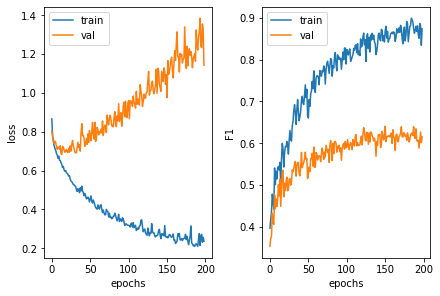

In [7]:
print("#######################################################################")
print("TRAIN MODEL")
train_loss = []
val_loss = []
train_score = []
val_score = []
max_score = 0
for epoch in range(1, epochs):

    model.train()

    total_loss = 0
    for batch, [data, labels] in enumerate(train_loader):
        optimizer.zero_grad()
        # breakpoint()
        out = model(data)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print("Epoch:{}\tTrain Loss:{}".format(epoch, total_loss / (batch + 1)), end="\t")
    train_loss.append(total_loss / (batch + 1))

    total_loss = 0
    for batch, [data, labels] in enumerate(val_loader):
        out = model(data)
        loss = criterion(out, labels)
        total_loss += loss.item()
    print("Val Loss:{}".format(total_loss / (batch + 1)), end="\t")
    val_loss.append(total_loss / (batch + 1))

    model.eval()

    pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
    true_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
    total = 0
    for batch, [data, labels] in enumerate(train_loader):
        out = model(data)
        out = torch.argmax(torch.nn.functional.softmax(out, dim=1), dim=1)
        pred_labels[total : total + len(labels)] = out.detach().cpu().numpy()
        true_labels[total : total + len(labels)] = labels.cpu().numpy()
        total += len(labels)
    pred_labels = pred_labels[:total]
    true_labels = true_labels[:total]
    train_score.append(
        f1_score(y_true=true_labels, y_pred=pred_labels, average="macro")
    )
    print("Train Score:{:.4f}".format(train_score[-1]), end="\t")

    pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
    true_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
    total = 0
    for batch, [data, labels] in enumerate(val_loader):
        out = model(data)
        out = torch.argmax(torch.nn.functional.softmax(out, dim=1), dim=1)
        pred_labels[total : total + len(labels)] = out.detach().cpu().numpy()
        true_labels[total : total + len(labels)] = labels.cpu().numpy()
        total += len(labels)
    pred_labels = pred_labels[:total]
    true_labels = true_labels[:total]
    val_score.append(f1_score(y_true=true_labels, y_pred=pred_labels, average="macro"))
    print("Val Score:{:.4f}\tMax Score:{:.4f}".format(val_score[-1], max_score))
    if max_score < val_score[-1]:
        max_score = val_score[-1]
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, "ANN.pt"))

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
ax = axs[0]
ax.plot(train_loss, label="train")
ax.plot(val_loss, label="val")
ax.legend()
ax.set_ylabel("loss")
ax.set_xlabel("epochs")
ax = axs[1]
ax.plot(train_score, label="train")
ax.plot(val_score, label="val")
ax.legend()
ax.set_ylabel("F1")
ax.set_xlabel("epochs")
plt.savefig(os.path.join(RESULT_DIR, "ANN.pdf"), format="pdf")
plt.show()

# TEST MODEL

In [8]:
print("#######################################################################")
print("LOAD MODEL")
model.load_state_dict(torch.load(os.path.join(MODEL_DIR, "ANN.pt")))
model.eval()

#######################################################################
LOAD MODEL


ANN(
  (fc_1): Linear(in_features=259, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
)

#######################################################################
TEST ON TRAIN SET
Scores:
              precision    recall  f1-score   support

    negative      0.929     0.954     0.942      2457
     neutral      0.913     0.843     0.877       738
    positive      0.797     0.784     0.791       491

    accuracy                          0.909      3686
   macro avg      0.880     0.860     0.870      3686
weighted avg      0.909     0.909     0.908      3686


Confusion_matrix:


<ipython-input-9-6416408b296f>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
<ipython-input-9-6416408b296f>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

<AxesSubplot:>

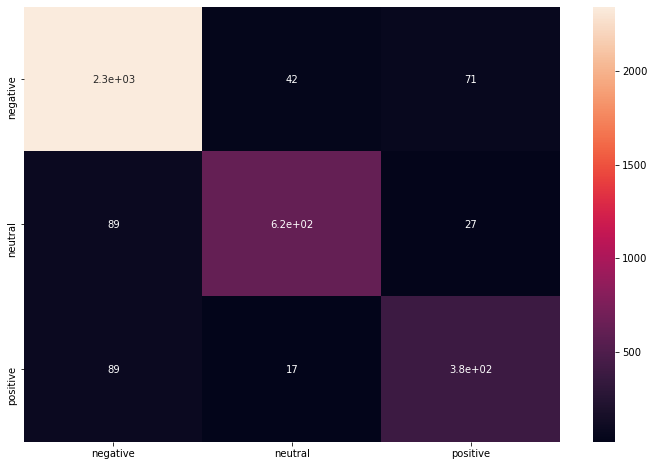

In [9]:
print("#######################################################################")
print("TEST ON TRAIN SET")
pred_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
true_labels = np.zeros(len(train_loader) * batch_size).astype(np.int)
total = 0
for batch, [data, labels] in enumerate(train_loader):
    out = model(data)
    out = torch.argmax(torch.nn.functional.softmax(out, dim=1), dim=1)
    pred_labels[total : total + len(labels)] = out.detach().cpu().numpy()
    true_labels[total : total + len(labels)] = labels.cpu().numpy()
    total += len(labels)
pred_labels = pred_labels[:total]
true_labels = true_labels[:total]
print("Scores:")
print(
    classification_report(true_labels, pred_labels, target_names=le.classes_, digits=3)
)
print("\nConfusion_matrix:")
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, le.classes_, le.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True)

#######################################################################
TEST ON VAL SET
Scores:
              precision    recall  f1-score   support

    negative      0.826     0.831     0.828       615
     neutral      0.665     0.647     0.656       184
    positive      0.435     0.439     0.437       123

    accuracy                          0.742       922
   macro avg      0.642     0.639     0.640       922
weighted avg      0.741     0.742     0.742       922


Confusion_matrix:


<ipython-input-10-705ae6bf67e5>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
<ipython-input-10-705ae6bf67e5>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information

<AxesSubplot:>

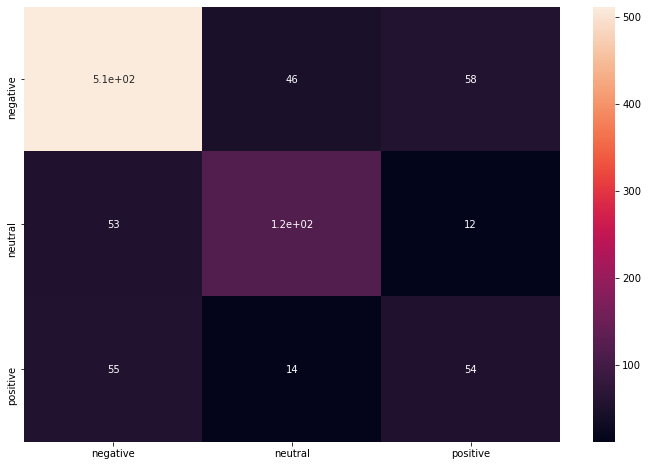

In [10]:
print("#######################################################################")
print("TEST ON VAL SET")
pred_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
true_labels = np.zeros(len(val_loader) * batch_size).astype(np.int)
total = 0
for batch, [data, labels] in enumerate(val_loader):
    out = model(data)
    out = torch.argmax(torch.nn.functional.softmax(out, dim=1), dim=1)
    pred_labels[total : total + len(labels)] = out.detach().cpu().numpy()
    true_labels[total : total + len(labels)] = labels.cpu().numpy()
    total += len(labels)
pred_labels = pred_labels[:total]
true_labels = true_labels[:total]
print("Scores:")
print(
    classification_report(true_labels, pred_labels, target_names=le.classes_, digits=3)
)
print("\nConfusion_matrix:")
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, le.classes_, le.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True)

#######################################################################
TEST ON TEST SET
Scores:
              precision    recall  f1-score   support

    negative      0.815     0.818     0.816       768
     neutral      0.595     0.574     0.584       230
    positive      0.472     0.487     0.479       154

    accuracy                          0.725      1152
   macro avg      0.627     0.626     0.626      1152
weighted avg      0.725     0.725     0.725      1152


Confusion_matrix:


<ipython-input-11-41d0bd210810>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred_labels = np.zeros(len(test_loader) * batch_size).astype(np.int)
<ipython-input-11-41d0bd210810>:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional informatio

<AxesSubplot:>

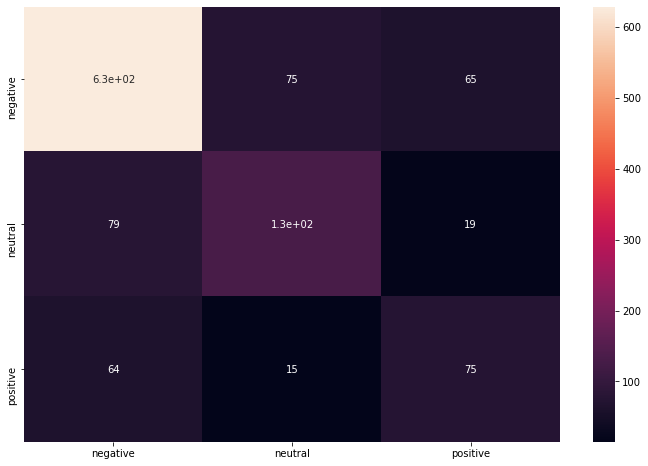

In [11]:
print("#######################################################################")
print("TEST ON TEST SET")
pred_labels = np.zeros(len(test_loader) * batch_size).astype(np.int)
true_labels = np.zeros(len(test_loader) * batch_size).astype(np.int)
total = 0
for batch, [data, labels] in enumerate(test_loader):
    out = model(data)
    out = torch.argmax(torch.nn.functional.softmax(out, dim=1), dim=1)
    pred_labels[total : total + len(labels)] = out.detach().cpu().numpy()
    true_labels[total : total + len(labels)] = labels.cpu().numpy()
    total += len(labels)
pred_labels = pred_labels[:total]
true_labels = true_labels[:total]
print("Scores:")
print(
    classification_report(true_labels, pred_labels, target_names=le.classes_, digits=3)
)
print("\nConfusion_matrix:")
cm = confusion_matrix(true_labels, pred_labels)
cm_df = pd.DataFrame(cm, le.classes_, le.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(cm_df, annot=True)